In [1]:
# ! wget http://images.cocodataset.org/zips/val2014.zip
# ! unzip -q val2014.zip
# ! wget https://raw.githubusercontent.com/tylin/coco-caption/master/annotations/captions_val2014.json

In [2]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data._utils.collate import default_collate
from pathlib import Path
from tqdm import tqdm
from itertools import chain


from pathlib import Path
from tqdm import tqdm
from itertools import chain
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from scipy.linalg import svdvals
import numpy as np
import seaborn as sns

import gc
import clip

sns.set_style("whitegrid")

In [3]:
class UniformCocoCaptions(CocoDetection):
    """`Same as torchvision.datasets.CocoCaptions, but 
    always outputs exactly 5 captions (for batch formation)
    """
    def __init__(self, root, annFile, transform=None, target_transform=None, transforms=None,
                style_caption=""):
        super().__init__(root, annFile, transform, target_transform, transforms)
        self.style_caption = style_caption
    def _load_target(self, id: int):
        return [self.style_caption + ann["caption"] for ann in super()._load_target(id)[:5]]

In [4]:
# ! pip install ftfy regex tqdm
# ! pip install git+https://github.com/openai/CLIP.git

In [5]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [6]:
@torch.no_grad()
def compute_clip_coco_embeds(clip_model_name, coco_images_dir, coco_captions_file,
                             batch_size=64, save_root=None,
                             image_embeds_filename_prefix=None,
                             text_embeds_filename_prefix=None,
                             save_all_texts=False,
                             style_caption=""):
    if not image_embeds_filename_prefix:
        image_embeds_filename_prefix = ''
    else:
        image_embeds_filename_prefix += '_'
    if not text_embeds_filename_prefix:
        text_embeds_filename_prefix = ''
    else:
        text_embeds_filename_prefix += '_'
    image_save_dir = Path(save_root) / 'image'
    image_save_dir.mkdir(parents=True, exist_ok=True)
    text_save_dir = Path(save_root) / 'text'
    text_save_dir.mkdir(parents=True, exist_ok=True)    

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
    print(f'Using {device}')
    print('Loading CLIP')
    model, preprocess = clip.load(clip_model_name)
    model.to(device)
    print('Done')
    dataset = UniformCocoCaptions(root=coco_images_dir,
                    annFile=coco_captions_file,
                    style_caption=style_caption,
                    transform=preprocess)
    print('COCO dataset:\n', dataset)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            pin_memory=torch.cuda.is_available(), num_workers=2)

    all_image_embeddings = []
    all_text_embeddings = []
    print('Computing embeddings')
    for batch in tqdm(dataloader):
        images, texts = batch
        image_input = images.to(device)
        # texsts have 5 tuples with batch_size texts
        # rearrange them, so that the 5 texts are next to each other
        texts = list(chain(*list(zip(*texts))))
        text_tokens = clip.tokenize(texts, truncate=True).to(device)
        image_features = model.encode_image(image_input).float()
        text_features = model.encode_text(text_tokens).float()
        all_image_embeddings.append(image_features)
        all_text_embeddings.append(text_features)
    all_image_embeddings = torch.cat(all_image_embeddings, dim=0)
    all_text_embeddings = torch.cat(all_text_embeddings, dim=0).reshape(-1, 5, 512)

    image_embeds_filename = image_embeds_filename_prefix + \
                            f'CLIP_{clip_model_name.replace("/", "-")}.pt'
    torch.save(all_image_embeddings, image_save_dir / image_embeds_filename)
    for i in range(5 if save_all_texts else 1):
        text_embeds_filename = text_embeds_filename_prefix + \
                               f'CLIP_{clip_model_name.replace("/", "-")}_{i}.pt'
        torch.save(torch.clone(all_text_embeddings[:, i, :]), text_save_dir / text_embeds_filename)
    print('Done')
    print(f'Image embeddings: {all_image_embeddings.shape}')
    print(f'Text  embeddings: {all_text_embeddings.shape}')
    gc.collect()


In [7]:
clip_models = [
               # 'RN50',
               # 'RN101',
               #'RN50x4',
               #'RN50x16',
               #'RN50x64',
               'ViT-B/32',
               #'ViT-B/16',
               #'ViT-L/14',
               #'ViT-L/14@336px']
              ]           
for clip_model_name in clip_models:
    print(clip_model_name)
    clip.load(clip_model_name)

ViT-B/32


# Compute embeddings of original and styled datasets

In [8]:
clip_model_name = 'ViT-B/32'
coco_images_dir = 'val2014_wave_preserve_color'
coco_captions_file = 'captions_val2014.json'
save_root = 'embeddings/coco_val2014_wave'
image_embeds_filename_prefix = None
text_embeds_filename_prefix = None
batch_size = 256
style_caption = "A painting in the style of The Great Wave off Kanagawa by Hokusai in which "

compute_clip_coco_embeds(clip_model_name, coco_images_dir, coco_captions_file,
                             batch_size, save_root,
                             image_embeds_filename_prefix,
                             text_embeds_filename_prefix,
                             style_caption=style_caption)

In [9]:
clip_model_name = 'ViT-B/32'
coco_images_dir = 'val2014_udnie_preserve_color'
coco_captions_file = 'captions_val2014.json'
save_root = 'embeddings/coco_val2014_udnie'
image_embeds_filename_prefix = None
text_embeds_filename_prefix = None
batch_size = 256
style_caption = "A painting in the style of Udnie by Picabia in which "

compute_clip_coco_embeds(clip_model_name, coco_images_dir, coco_captions_file,
                             batch_size, save_root,
                             image_embeds_filename_prefix,
                             text_embeds_filename_prefix,
                             style_caption=style_caption)

In [10]:
clip_model_name = 'ViT-B/32'
coco_images_dir = 'val2014'
coco_captions_file = 'captions_val2014.jsn'
save_root = 'embeddings/coco_val2014'
image_embeds_filename_prefix = None
text_embeds_filename_prefix = None
batch_size = 256
style_caption = ""

compute_clip_coco_embeds(clip_model_name, coco_images_dir, coco_captions_file,
                             batch_size, save_root,
                             image_embeds_filename_prefix,
                             text_embeds_filename_prefix)

# Look at embeddings

In [11]:
clip_filename = 'CLIP_ViT-B-32'

image_embeddings = torch.load(f'./embeddings/coco_val2014/image/{clip_filename}.pt', map_location='cpu')
text_embeddings = torch.load(f'./embeddings/coco_val2014/text/{clip_filename}_0.pt', map_location='cpu')

wave_image_embeddings = torch.load(f'./embeddings/coco_val2014_wave/image/{clip_filename}.pt', map_location='cpu')
wave_text_embeddings = torch.load(f'./embeddings/coco_val2014_wave/text/{clip_filename}_0.pt', map_location='cpu')

udnie_image_embeddings = torch.load(f'./embeddings/coco_val2014_udnie/image/{clip_filename}.pt', map_location='cpu')
udnie_text_embeddings = torch.load(f'./embeddings/coco_val2014_udnie/text/{clip_filename}_0.pt', map_location='cpu')

In [12]:
def centered(embedding_matrix):
    return embedding_matrix - embedding_matrix.mean(0)

def normed(embedding_matrix):
    if isinstance(embedding_matrix, torch.Tensor):
        return embedding_matrix / embedding_matrix.norm(dim=-1, keepdim=True) 
    return embedding_matrix / np.linalg.norm(embedding_matrix, axis=-1, keepdims=True)

In [13]:
def embedding_visualisation(embedding_matrix, centering=False, divide=False):
    if centering:
        embedding_matrix = centered(embedding_matrix)
    svd = TruncatedSVD(n_components=2)
    svd.fit(embedding_matrix)
    comp_tr = np.transpose(svd.components_)
    proj = np.dot(embedding_matrix, comp_tr)

    svs = svdvals(embedding_matrix)
    svs /= svs.max()

    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    if not divide:
        plt.scatter(proj[:, 0], proj[:, 1], s=1, alpha=0.1)
    else:
        half = embedding_matrix.shape[0] // 2
        plt.scatter(proj[:half, 0], proj[:half, 1], s=1, alpha=0.1, label='image')
        plt.scatter(proj[half:, 0], proj[half:, 1], s=1, alpha=0.1, label='text')
        leg = plt.legend()
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
    plt.scatter([0], [0], c='r', marker='+', s=100)
    plt.axis('scaled')
    plt.xlabel('SVD component 1')
    plt.ylabel('SVD component 2')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(len(svs)), svs)
    plt.ylim(-0.1, 1.1)
    plt.xlabel('Index')
    plt.ylabel('Normalized Singular Value')

    return proj, svs

# Udnie style:

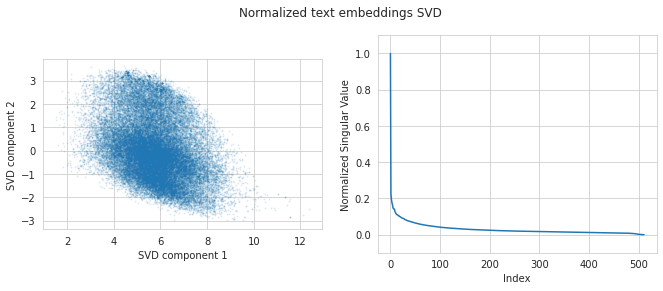

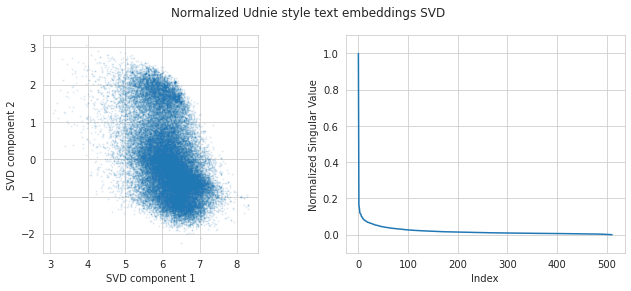

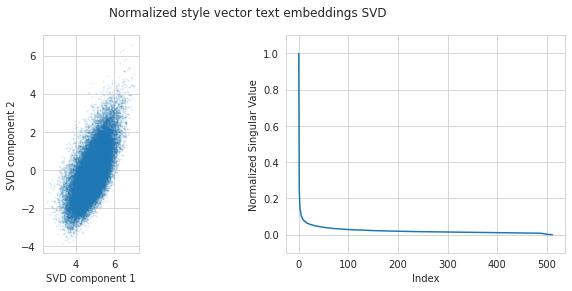

In [14]:
embedding_visualisation(text_embeddings.cpu().numpy())
plt.suptitle('Normalized text embeddings SVD')
plt.show()
embedding_visualisation(udnie_text_embeddings.cpu().numpy())
plt.suptitle('Normalized Udnie style text embeddings SVD')
plt.show()
embedding_visualisation((text_embeddings - udnie_text_embeddings).cpu().numpy())
plt.suptitle('Normalized style vector text embeddings SVD')
plt.show()

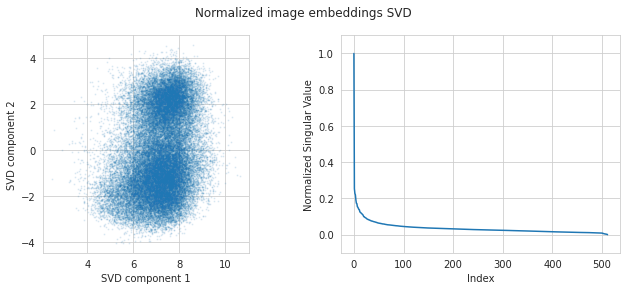

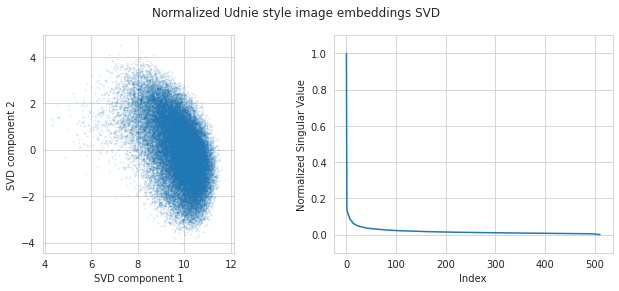

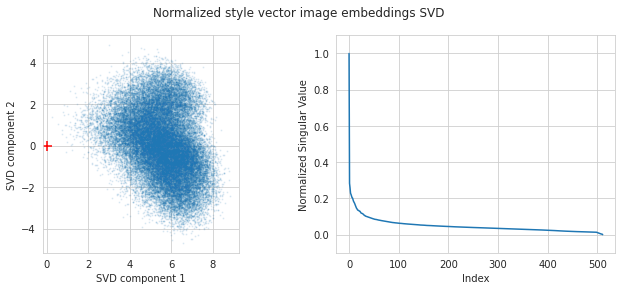

In [15]:
embedding_visualisation(image_embeddings.cpu().numpy())
plt.suptitle('Normalized image embeddings SVD')
plt.show()
embedding_visualisation(udnie_image_embeddings.cpu().numpy())
plt.suptitle('Normalized Udnie style image embeddings SVD')
plt.show()
embedding_visualisation((image_embeddings - udnie_image_embeddings).cpu().numpy())
plt.suptitle('Normalized style vector image embeddings SVD')
plt.show()

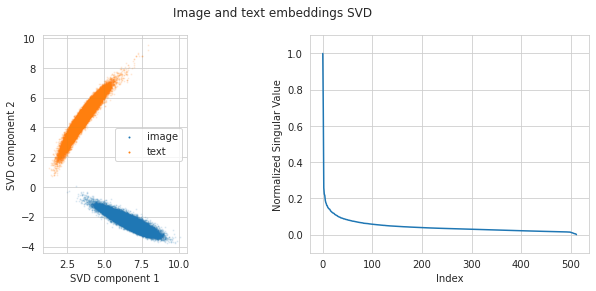

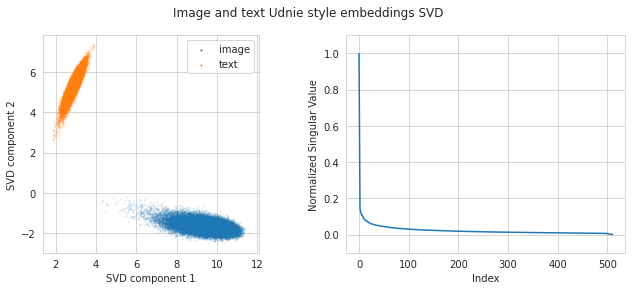

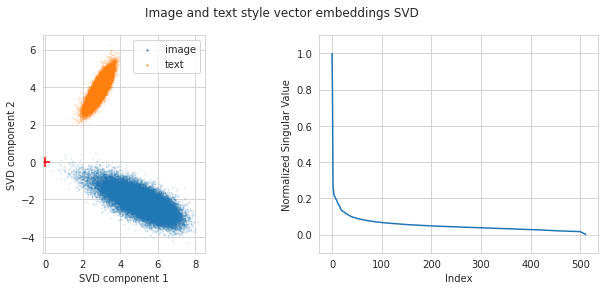

In [16]:
embedding_visualisation(torch.cat([image_embeddings, text_embeddings], 0).cpu().numpy(), divide=True)
plt.suptitle('Image and text embeddings SVD')
plt.show()
embedding_visualisation(torch.cat([udnie_image_embeddings, udnie_text_embeddings], 0).cpu().numpy(), divide=True)
plt.suptitle('Image and text Udnie style embeddings SVD')
plt.show()
embedding_visualisation(torch.cat([image_embeddings - udnie_image_embeddings, text_embeddings - udnie_text_embeddings], 0).cpu().numpy(), divide=True)
plt.suptitle('Image and text style vector embeddings SVD')
plt.show()

In [17]:
def corr2_coeff(A, B):
    A_mA = A - A.mean(1)[:, None]
    B_mB = B - B.mean(1)[:, None]

    ssA = (A_mA**2).sum(1)
    ssB = (B_mB**2).sum(1)

    return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None],ssB[None]))

In [25]:
img_text_corr = corr2_coeff(image_embeddings.cpu().numpy()[:5000], text_embeddings.cpu().numpy()[:5000])

In [19]:
udnie_img_text_corr = corr2_coeff(udnie_image_embeddings.cpu().numpy()[:5000], udnie_text_embeddings.cpu().numpy()[:5000])

In [24]:
img_text_corr.shape, udnie_img_text_corr.shape

((35504, 5000), (5000, 5000))

In [26]:
off_diag = ~np.eye(img_text_corr.shape[0], dtype=bool)

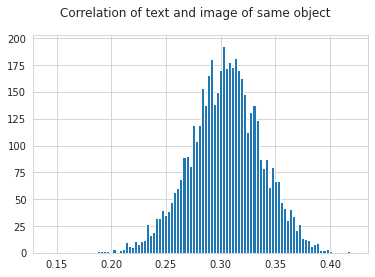

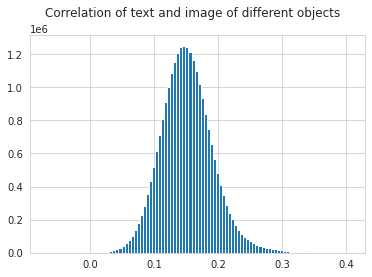

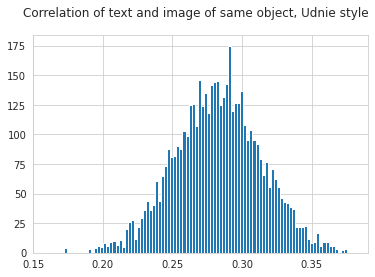

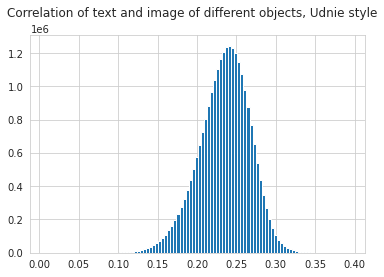

In [27]:
plt.suptitle("Correlation of text and image of same object")
plt.hist(img_text_corr[~off_diag], bins=100)
plt.show();

plt.suptitle("Correlation of text and image of different objects")
plt.hist(img_text_corr[off_diag], bins=100)
plt.show();

plt.suptitle("Correlation of text and image of same object, Udnie style")
plt.hist(udnie_img_text_corr[~off_diag], bins=100)
plt.show();

plt.suptitle("Correlation of text and image of different objects, Udnie style")
plt.hist(udnie_img_text_corr[off_diag], bins=100)
plt.show();

# Wave style:

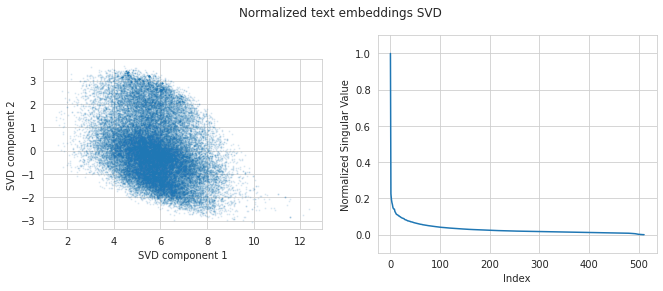

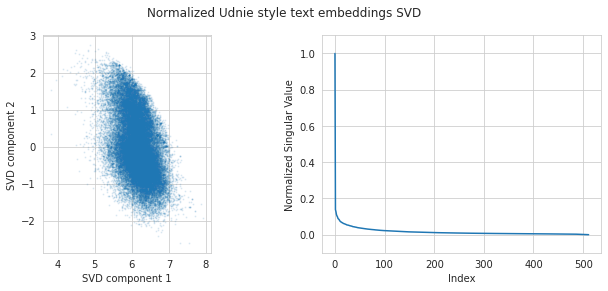

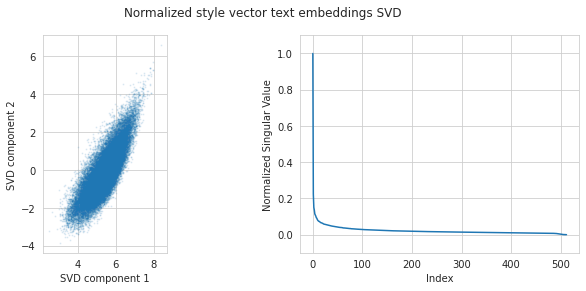

In [23]:
embedding_visualisation(text_embeddings.cpu().numpy())
plt.suptitle('Normalized text embeddings SVD')
plt.show()
embedding_visualisation(wave_text_embeddings.cpu().numpy())
plt.suptitle('Normalized Udnie style text embeddings SVD')
plt.show()
embedding_visualisation((text_embeddings - wave_text_embeddings).cpu().numpy())
plt.suptitle('Normalized style vector text embeddings SVD')
plt.show()

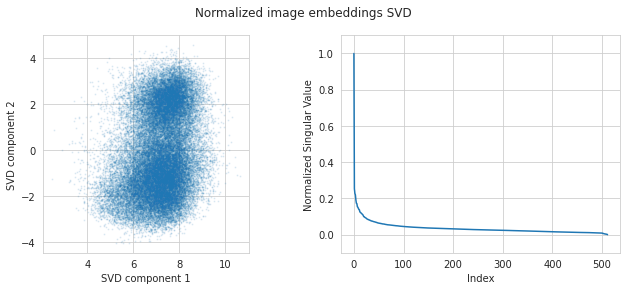

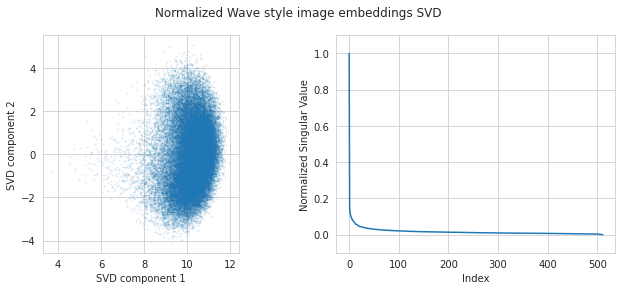

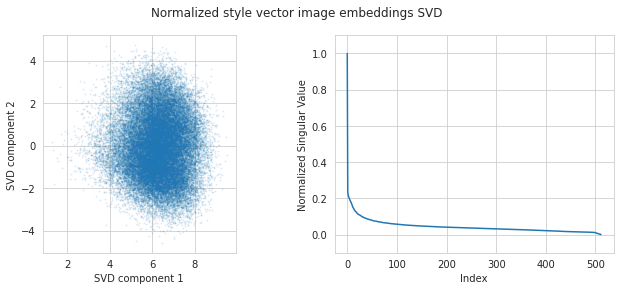

In [25]:
embedding_visualisation(image_embeddings.cpu().numpy())
plt.suptitle('Normalized image embeddings SVD')
plt.show()
embedding_visualisation(wave_image_embeddings.cpu().numpy())
plt.suptitle('Normalized Wave style image embeddings SVD')
plt.show()
embedding_visualisation((image_embeddings - wave_image_embeddings).cpu().numpy())
plt.suptitle('Normalized style vector image embeddings SVD')
plt.show()

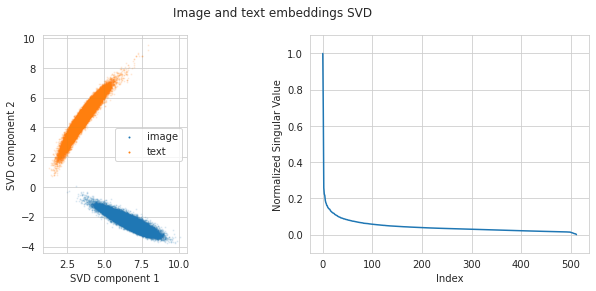

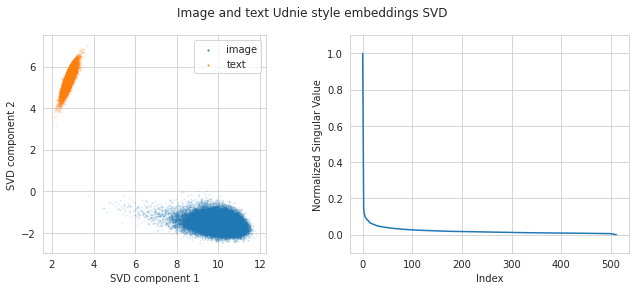

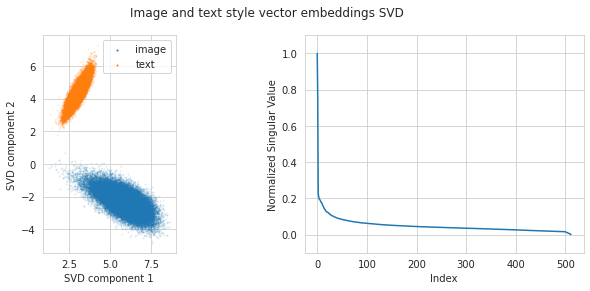

In [26]:
embedding_visualisation(torch.cat([image_embeddings, text_embeddings], 0).cpu().numpy(), divide=True)
plt.suptitle('Image and text embeddings SVD')
plt.show()
embedding_visualisation(torch.cat([wave_image_embeddings, wave_text_embeddings], 0).cpu().numpy(), divide=True)
plt.suptitle('Image and text Wave style embeddings SVD')
plt.show()
embedding_visualisation(torch.cat([image_embeddings - wave_image_embeddings, text_embeddings - wave_text_embeddings], 0).cpu().numpy(), divide=True)
plt.suptitle('Image and text style vector embeddings SVD')
plt.show()

In [ ]:
img_text_corr = corr2_coeff(image_embeddings.cpu().numpy(), text_embeddings.cpu().numpy())

In [ ]:
off_diag = ~np.eye(img_text_corr.shape[0], dtype=bool)

plt.suptitle("Correlation of text and image of same object")
plt.hist(img_text_corr[~off_diag], bins=100)
plt.show();

plt.suptitle("Correlation of text and image of different objects")
plt.hist(img_text_corr[off_diag], bins=100)
plt.show();